# Comparison of All Models - Backtesting, Vizualization

This notebook compares all internal models, as well as the standard formula approach. The comparison will be done with the implemented backtesting in mind. 

Additional plots, and vizualizations might be presented.

# Lage innholdsfortegnelse

In [1]:
from internal_models.historical_simulation.historical_simulation import HistoricalSimulation
from internal_models.montecarlo.mc_copula import MonteCarloCopula
from internal_models.montecarlo.mc_vanillagbm import MonteCarloVanillaGBM
from internal_models.montecarlo.mc_jumpgbm import MonteCarloJumpGBM
from backtesting.var_tests.christoffersens_test import christoffersen_independence_test
from backtesting.var_tests.kupiec_test import kupiec_pof_test
from internal_models.GANs.tuned_GANS import solveig_GAN, astrid_GAN, willow_GAN
from utilities.bof_var_plot import plot_bof_var
from utilities.model_saving import save_results, is_results_empty, load_results
from utilities.bof_var_plot import plot_bof_var
from utilities.gan_plotting import extensive_plotting

import pandas as pd
from tqdm import tqdm
import numpy as np
from dotenv.main import load_dotenv
import matplotlib.pyplot as plt
import seaborn as sns
load_dotenv(override=True)
import os

### Fixing the data. Splitting the data in a testing period.

Split date is set inside environment file.

In [2]:
def fetch_data_df():
    # Load the data
    df = pd.read_csv('data/final_daily_returns_asset_classes.csv', index_col=0, parse_dates=True)
    df.index = pd.to_datetime(df.index)
    start_test_date = os.getenv("START_TEST_DATE")
    
    if start_test_date is None:
        raise ValueError("Environment variable 'START_TEST_DATE' is not set.")

    start_test_date = pd.to_datetime(start_test_date)
    
    pre_test_df = df[df.index < start_test_date]
    test_df = df[df.index >= start_test_date].iloc[:252]
    
    return pre_test_df, test_df

returns_df, test_returns_df = fetch_data_df()

### Deciding on weights for portfolio

**ATTENTION:** Assuming an equally weighted portfolio for now

In [3]:
num_assets = returns_df.shape[1]
weights = np.full(num_assets, 1 / num_assets)  

### Other Parameters

In [4]:
assets_0 = int(os.getenv("INIT_ASSETS"))
liabilities_0 = int(os.getenv("INIT_ASSETS")) * float(os.getenv("FRAC_LIABILITIES"))
num_simulations = int(os.getenv("N_SIMULATIONS"))
bof_0 = assets_0 - liabilities_0

## Calculating SCR with common Internal Models

I.e the following models:

- Historical Simulation
- Monte Carlo simulations with Copulas (Student t's)
- Monte Carlo, vanilla GBM. No correlations between assets assumed
- Monte Carlo, GBM with jumps and correlations between assets

In [5]:
hs = HistoricalSimulation(returns_df, weights)
mc_copula = MonteCarloCopula(returns_df, weights)
mc_vanilla_GBM = MonteCarloVanillaGBM(returns_df, weights)
mc_jump_gbm = MonteCarloJumpGBM(returns_df, weights)

## Decide on using saved model results, or recalculating

In [6]:
use_saved = True

In [7]:
if not use_saved or is_results_empty():
    dist_hs, scr_hs = hs.calculate_distribution_and_scr()
    save_results(model_name="Historical Simulation", distribution=dist_hs, scr=scr_hs, weights=weights, overwrite=True)

    dist_mc_copula, scr_mc_copula = mc_copula.calculate_distribution_and_scr()
    save_results(model_name="MC Copula", distribution=dist_mc_copula, scr=scr_mc_copula, weights=weights, overwrite=False)

    dist_mc_vanilla_gbm, scr_mc_vanilla_gbm = mc_vanilla_GBM.calculate_distribution_and_scr()
    save_results(model_name="MC Vanilla GBM", distribution=dist_mc_vanilla_gbm, scr=scr_mc_vanilla_gbm, weights=weights, overwrite=False)

    dist_mc_jump_gbm, scr_mc_jump_gbm = mc_jump_gbm.calculate_distribution_and_scr()
    save_results(model_name="GBM with Poisson Jumps and Intra-Asset Correlations", distribution=dist_mc_jump_gbm, scr=scr_mc_jump_gbm, weights=weights, overwrite=False)

## Plotting Distributions and displaying the SCR

Where the SCR is the Value-at-Risk at 99.5%. 

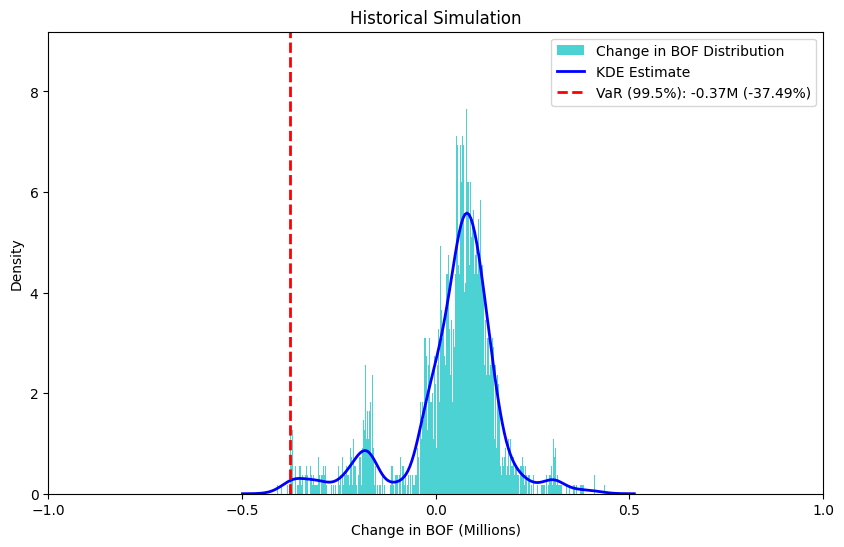

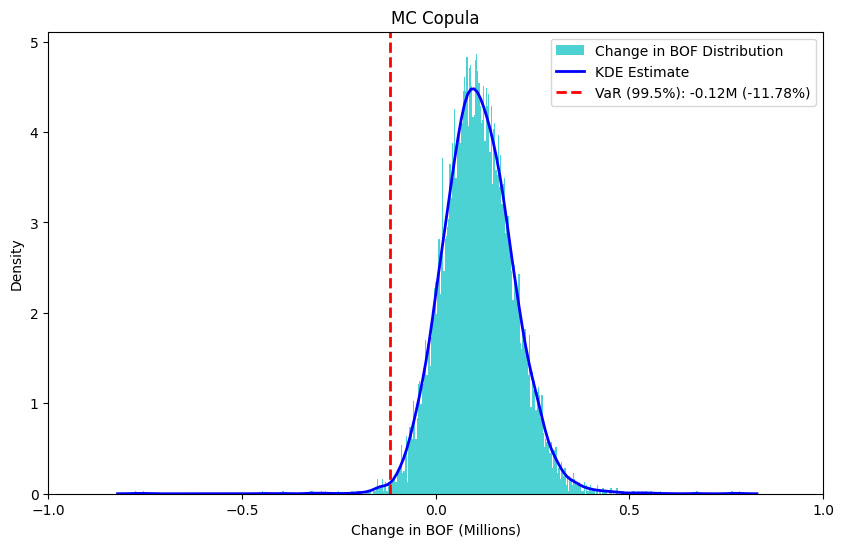

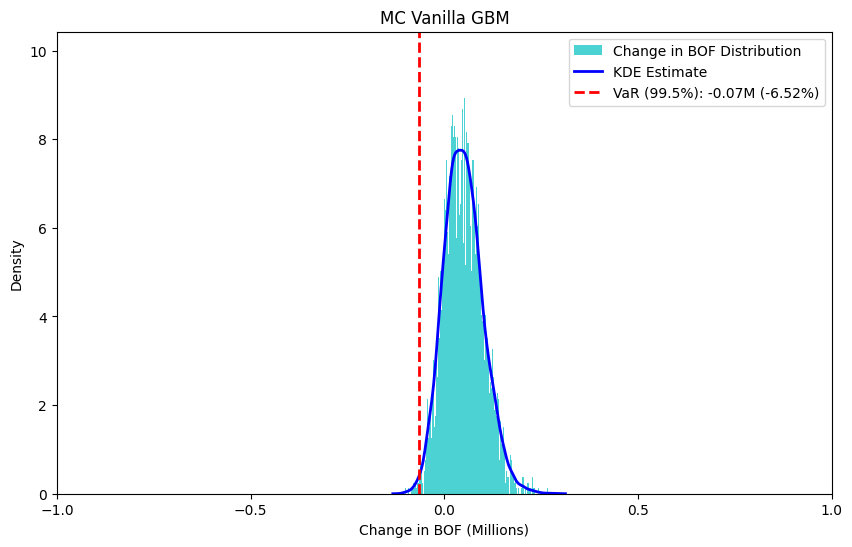

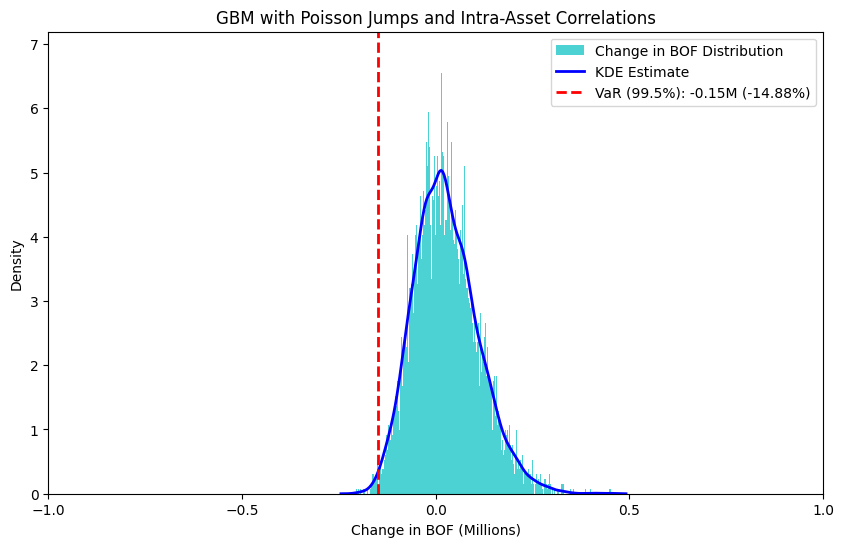

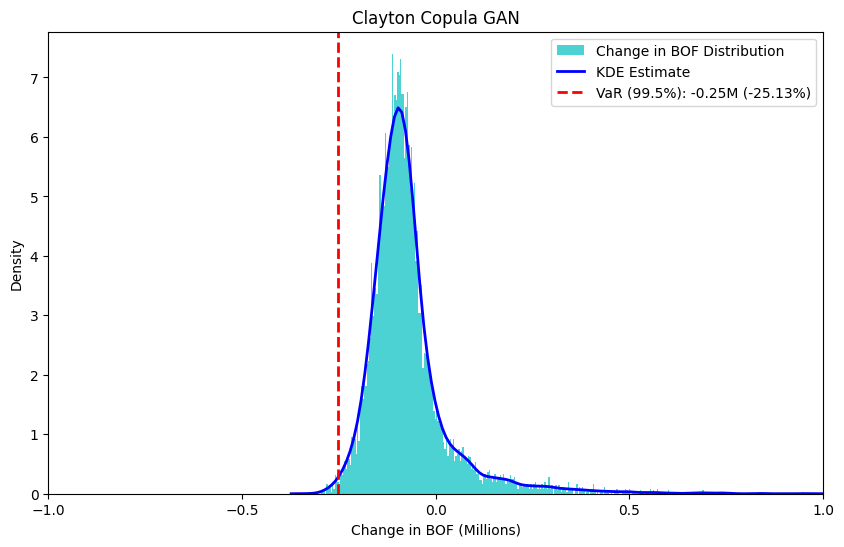

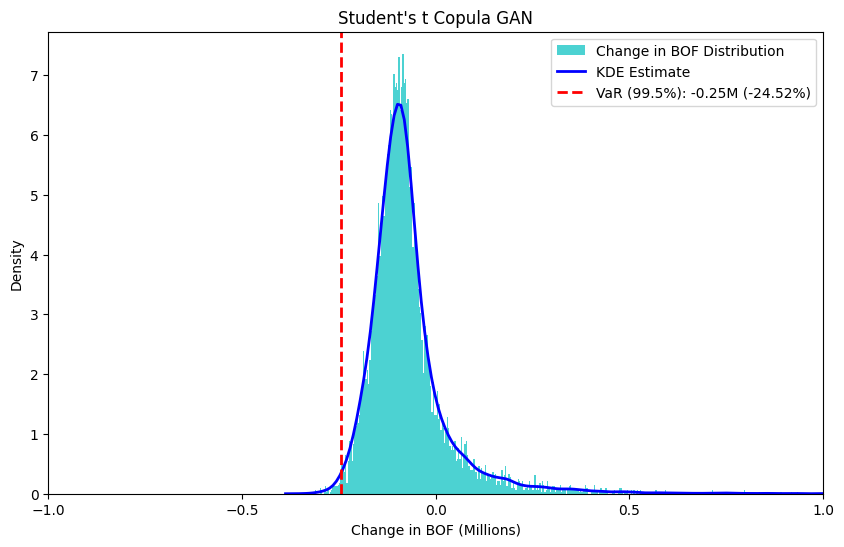

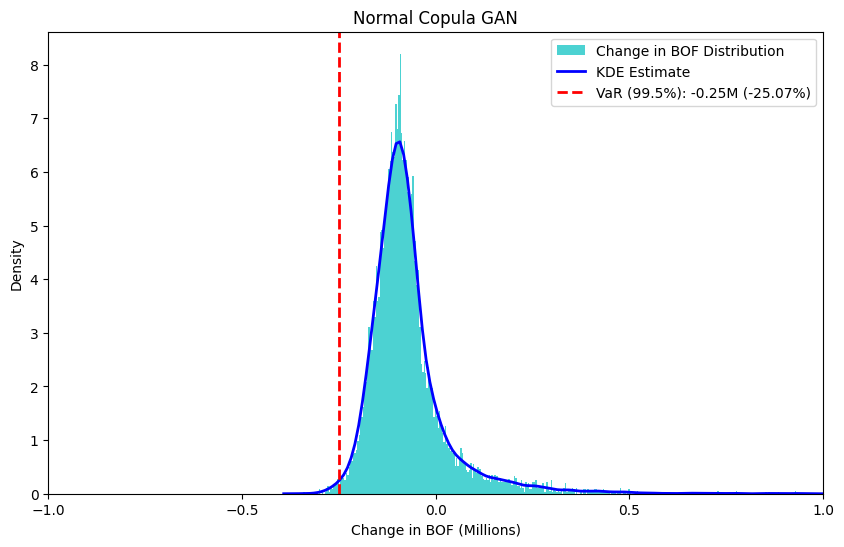

In [8]:
results = load_results()
for model_name, result in results.items():
    plot_bof_var(result['distribution'], result['scr'], model_name, bof_0),

## Internal Models using Neural Networks - GANs

Relevant plots:
- Generated distributions for each asset class, with statistics
- PCA plot
- Tests relevant to GANs
    - Mode Collaps
    - Variance
    - Wasserstein distance plot

A GAN is trained on each asset class, creating generated distribution for 1 year ahead. These distributions are then aggregated using Copulas.

In [9]:
from internal_models.GANs.tuned_GANS.astrid_GAN import AstridGAN
from internal_models.GANs.tuned_GANS.willow_GAN import WillowGAN

## Training the GANs if spesified, otherwise the already generated returns will be used

In [10]:
train_gans = False

In [11]:
if train_gans:
    for asset_name in tqdm(returns_df.columns, desc="Training GANs", unit="asset"):
        print(f"Training GAN for {asset_name}...")
        asset_returns = returns_df[asset_name]

        if asset_name == 'EONIA':
            gan = WillowGAN(asset_returns, asset_name)
        else:
            gan = AstridGAN(asset_returns, asset_name)
        
        gan.train()
        
        print(f"Finished training GAN for {asset_name}.\n")

        gan.generate_scenarios(num_scenarios=num_simulations)

        print(f"Finished generating scenarios GAN {asset_name}.\n")

Presenting GAN results

In [12]:
#extensive_plotting(scaled=False, returns_df=returns_df)

## Add a Preliminary backtesting for each individual GAN

This is meant as a preliminary backtesting for each asset created by individual GANs. Backtesting is done on returns, not BOF (yet).

1. Backtesting plots will be presented
2. Statistical tests will be made
3. Accuracy/adaquecy tests will be made

In [13]:
from utilities.backtesting_plots import backtest_var_single_asset
from utilities.gan_plotting import load_generated_returns
from backtesting.perform_var_tests import perform_var_backtesting_tests
from backtesting.perform_distribution_tests import perform_distribution_tests
from utilities.gan_plotting import create_rolling_empirical

'''
for asset_name in returns_df.columns:
    generated_returns = load_generated_returns(asset_name)
    failures = backtest_var_single_asset(test_returns_df[asset_name], generated_returns, asset_name)
    perform_var_backtesting_tests(failures=failures, returns=test_returns_df[asset_name], var_forecast=None, asset_name=asset_name, generated_returns=generated_returns)
    perform_distribution_tests(generated_returns=generated_returns, empirical_returns_rolling=create_rolling_empirical(returns_df[asset_name]), asset_name = asset_name)'
    '''


"\nfor asset_name in returns_df.columns:\n    generated_returns = load_generated_returns(asset_name)\n    failures = backtest_var_single_asset(test_returns_df[asset_name], generated_returns, asset_name)\n    perform_var_backtesting_tests(failures=failures, returns=test_returns_df[asset_name], var_forecast=None, asset_name=asset_name, generated_returns=generated_returns)\n    perform_distribution_tests(generated_returns=generated_returns, empirical_returns_rolling=create_rolling_empirical(returns_df[asset_name]), asset_name = asset_name)'\n    "

## Aggregating the GAN distributions together - Copulas

When aggregated we display the BOF distribtion, as well as the SCR.


In [14]:
from internal_models.multivariate_GAN.students_copula_GAN import StudentsCopulaGAN 
from internal_models.multivariate_GAN.normal_copula_GAN import CopulaGANNormal
from internal_models.multivariate_GAN.clayton_copula_GAN import CopulaGANClayton

## A Little Check on how many of EONIA Returns are NaN

In [15]:
eonia_samples = load_generated_returns('EONIA')
if hasattr(eonia_samples, "cpu"):
    eonia_samples = eonia_samples.cpu().numpy()
else:
    eonia_samples = np.array(eonia_samples)
total_values = eonia_samples.size
nan_count = np.isnan(eonia_samples).sum()
print(f"EONIA NaN count: {nan_count} out of {total_values} ({nan_count/total_values*100:.2f}%)")

EONIA NaN count: 441554 out of 2520000 (17.52%)


In [16]:
from utilities.clean_eonia import clean_eonia

eonia_samples = clean_eonia(eonia_samples)

In [17]:
total_values = eonia_samples.size
nan_count = np.isnan(eonia_samples).sum()
print(f"EONIA NaN count: {nan_count} out of {total_values} ({nan_count/total_values*100:.2f}%)")

EONIA NaN count: 0 out of 2520000 (0.00%)


## Prepering generated GAN returns for Copula

The GANs produce for each scenario (singular input) a 252-day distribution of returns. This is done for each generated scenario.

The GAN returns have shape: Num simulation x 252 days x 7 assets. This leads to a computational problem. Therefore this dimensionality must be reduced somehow. We have decided to reduce this dimensionality by transforming to cumulative returns, giving us a new shape of Num simulation x 7 assets.

In [18]:
gan_samples_list = []
for asset_name in returns_df.columns:

    generated_returns = load_generated_returns(asset_name)

    if hasattr(generated_returns, "cpu"):
        generated_returns = generated_returns.cpu().numpy()
    else:
        generated_returns = np.array(generated_returns)

    if asset_name == 'EONIA':
        generated_returns = eonia_samples
        
    cumulative_returns = np.prod(1 + generated_returns, axis=1) - 1  # shape: (10000,)
    gan_samples_list.append(cumulative_returns)

# Stack these to get an array of shape (10000, n_assets)
gan_samples = np.column_stack(gan_samples_list)


Each Copula implementation gets the cummulative one year ahead distribution for each asset class produced by the GAN. These distributions are visualized below. 

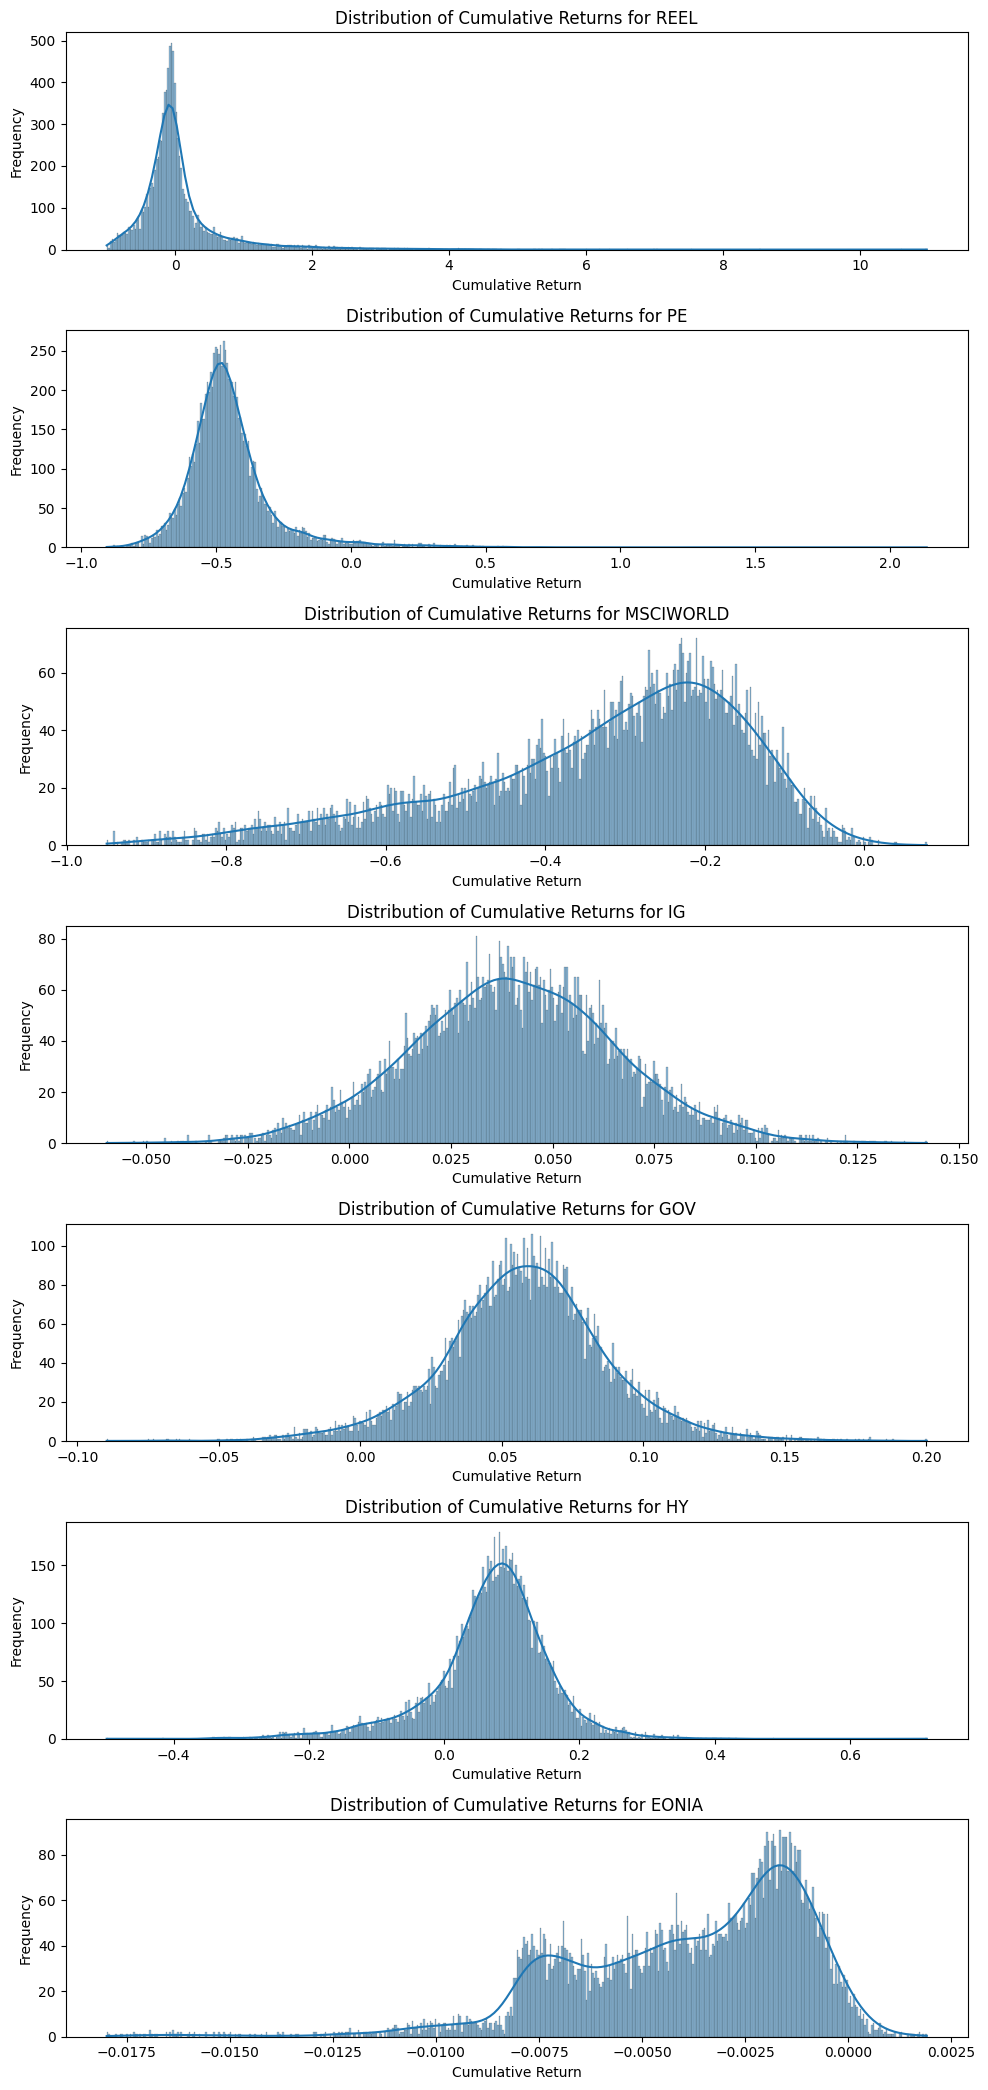

In [19]:
n_assets = gan_samples.shape[1]
fig, axes = plt.subplots(n_assets, 1, figsize=(10, 3 * n_assets), sharex=False)

# If there's only one asset, wrap axes in a list for uniformity.
if n_assets == 1:
    axes = [axes]

for i in range(n_assets):
    ax = axes[i]
    sns.histplot(gan_samples[:, i], bins=500, kde=True, ax=ax)
    ax.set_title(f"Distribution of Cumulative Returns for {returns_df.columns[i]}")
    ax.set_xlabel("Cumulative Return")
    ax.set_ylabel("Frequency")

plt.tight_layout()
plt.show()

Creating the Copulas:

- Student's t
- Gaussian
- Clayton

In [20]:
if train_gans: 
    student_gan = StudentsCopulaGAN(
    gan_samples=gan_samples,
    weights=weights
    )
    dist_student_gan, scr_student_gan = student_gan.calculate_distribution_and_scr()
    plot_bof_var(dist_student_gan, scr_student_gan, "Student's t Copula GAN", bof_0)

    save_results(model_name="Student's t Copula GAN", distribution=dist_student_gan, scr=scr_student_gan, weights=weights, overwrite=False)

    normal_multi_gan = CopulaGANNormal(
        gan_samples=gan_samples,
        weights=weights
    )
    dist_normal_gan, scr_normal_gan = normal_multi_gan.calculate_distribution_and_scr()
    plot_bof_var(dist_normal_gan, scr_normal_gan, "Normal Copula GAN", bof_0)

    save_results(model_name="Normal Copula GAN", distribution=dist_normal_gan, scr=scr_normal_gan, weights=weights, overwrite=False)
    
    clayton_gan = CopulaGANClayton(
        gan_samples=gan_samples,
        weights=weights
    )
    dist_clayton_gan, scr_clayton_gan = clayton_gan.calculate_distribution_and_scr()
    plot_bof_var(dist_clayton_gan, scr_clayton_gan, 'Clayton Copula GAN', bof_0)

    save_results(model_name='Clayton Copula GAN', distribution=dist_clayton_gan, scr=scr_clayton_gan, weights=weights, overwrite=False)

## Exploring a Conditional GAN
 - By adding marketviews through the condition, we might be able to pass the tests?

## Adding Standard Formula

Potential issues: Is the standard formula time dependent?

In [21]:
from standard_formula.sf import calculate_market_scr
from utilities.map_weights_to_assets import map_weights_to_assets

asset_values = map_weights_to_assets(returns_df, weights)

durations = {
    'gov_bonds': 7.29,
    'IG_corp_bonds': 5.90,
    'HY_corp_bonds': 3.14
}

sf_scr = calculate_market_scr(asset_values, durations)
for key, value in sf_scr.items():
    print(f"{key}: {value:,.3f}")

sf_market_scr = -sf_scr['Total Market SCR'] * assets_0


Market SCR Interest: 0.082
Market SCR Equity: 0.118
Market SCR Real Estate: 0.036
Market SCR Spread: 0.045
Total Market SCR: 0.237


## Performing Backtesting

On 1-year out of sample data, the start of the testing period is defined as START_TEST_DATE inside .env.


+-----------------------------------------+
|                                         |
|          Historical Simulation          |
|                                         |
+-----------------------------------------+


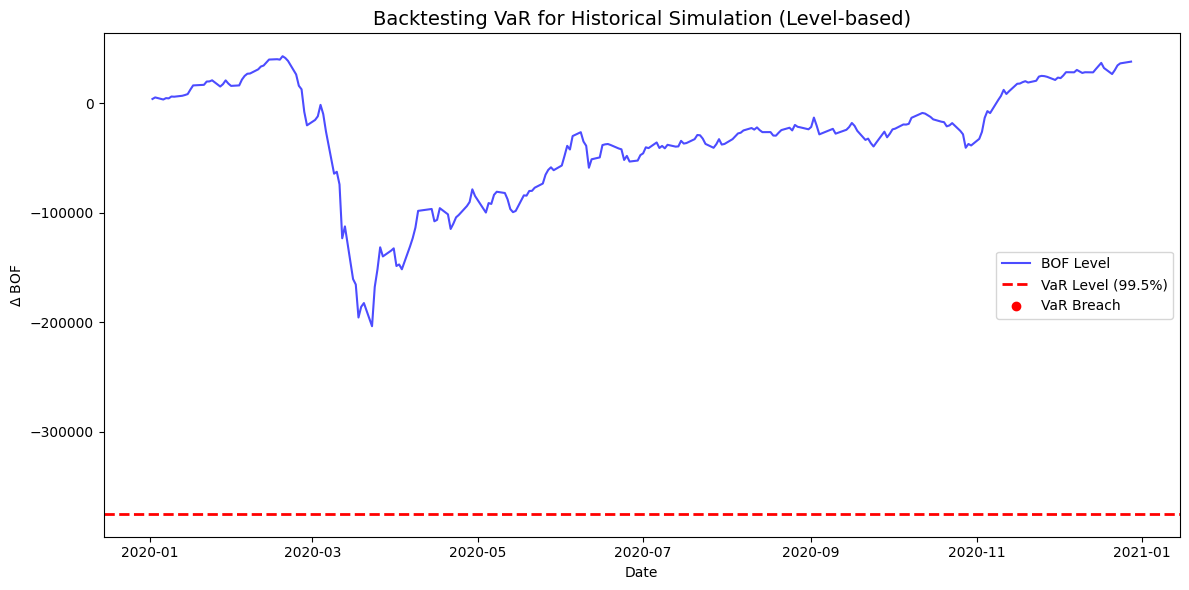


📊 VaR Backtesting Summary for Historical Simulation:
• Confidence Level: 99.5%
• VaR Threshold (Level): -374857.801135
• Failures (BOF below VaR): 0 times


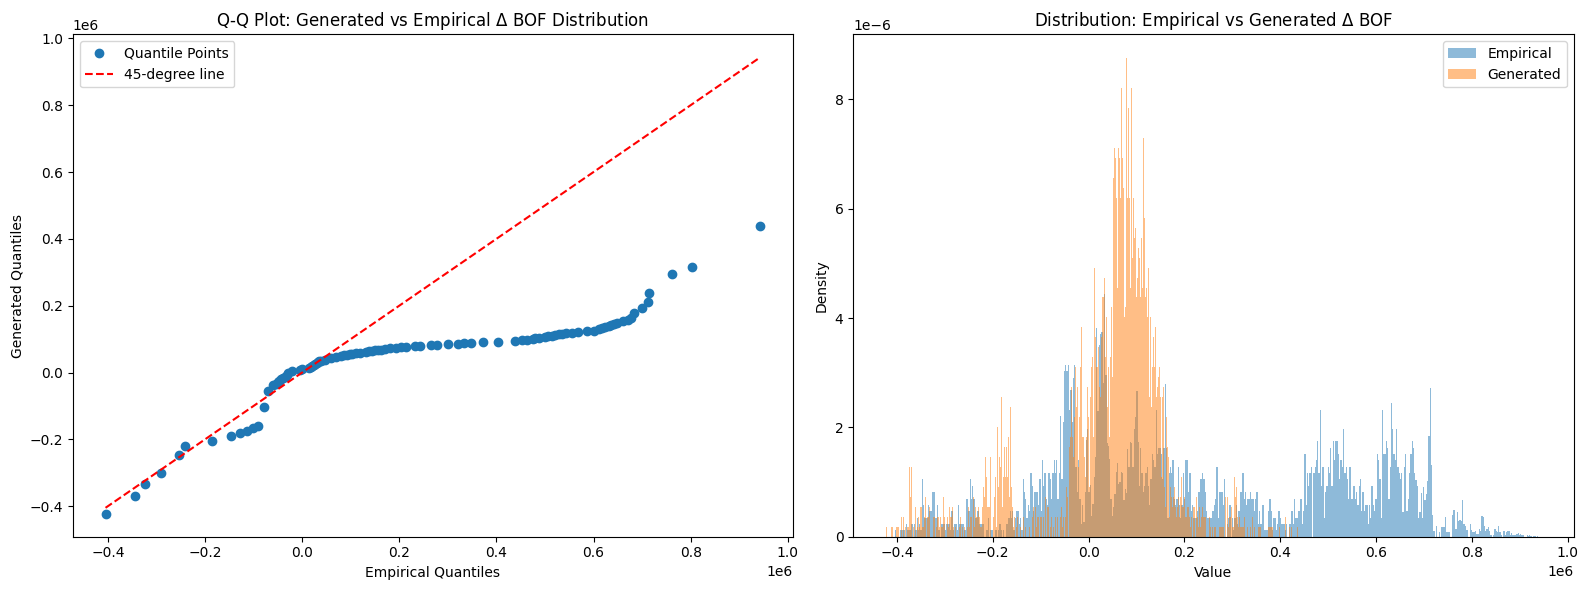

empirical returns rolling shape (3187, 252)


ValueError: X has 1 features, but PCA is expecting 252 features as input.

In [22]:
# Make verbose if you want to visualize more

from backtesting.run_all_tests_on_models import run_all_tests_on_models

benchmark = load_results()
models = {model_name: data["distribution"] for model_name, data in benchmark.items()}

models['Standard Formula'] = sf_market_scr

var_df, dist_df = run_all_tests_on_models(models, returns_df, test_returns_df, weights, assets_0, liabilities_0, verbose=True)

In [ ]:
var_df

model_name,LR_pof,p_value_pof,result_pof,LR_ind,p_value_ind,result_ind,LR_joint,p_value_joint,result_joint,avg_lopez_loss,balanced_scr_loss
Historical Simulation,2.526321,0.111961,✅ Passed (p > 0.1) - No significant failure pattern detected 🎉,-0.000000,1.000000,✅ Passed (p > 0.1) - No clustering of VaR breaches 🎉,2.526321,0.282759,✅ Passed (p > 0.1) - Joint test does not reject model adequacy 🎉,0.000000,171412.414970
MC Copula,63.396700,0.000000,❌ Failed (p < 0.1) - VaR model may be misspecified ⚠️,129.390935,0.000000,❌ Failed (p < 0.1) - VaR breaches are clustered ⚠️,192.787635,0.000000,❌ Failed (p < 0.1) - Joint test indicates model misspecification ⚠️,0.081217,45502.739853
MC Vanilla GBM,296.454056,0.000000,❌ Failed (p < 0.1) - VaR model may be misspecified ⚠️,255.647368,0.000000,❌ Failed (p < 0.1) - VaR breaches are clustered ⚠️,552.101424,0.000000,❌ Failed (p < 0.1) - Joint test indicates model misspecification ⚠️,0.377240,26616.080273
GBM with Poisson Jumps and Intra-Asset Correlations,20.151452,0.000007,❌ Failed (p < 0.1) - VaR model may be misspecified ⚠️,77.508295,0.000000,❌ Failed (p < 0.1) - VaR breaches are clustered ⚠️,97.659746,0.000000,❌ Failed (p < 0.1) - Joint test indicates model misspecification ⚠️,0.037237,59266.647414
Clayton Copula GAN,2.526321,0.111961,✅ Passed (p > 0.1) - No significant failure pattern detected 🎉,-0.000000,1.000000,✅ Passed (p > 0.1) - No clustering of VaR breaches 🎉,2.526321,0.282759,✅ Passed (p > 0.1) - Joint test does not reject model adequacy 🎉,0.000000,109631.913902
Student's t Copula GAN,2.526321,0.111961,✅ Passed (p > 0.1) - No significant failure pattern detected 🎉,-0.000000,1.000000,✅ Passed (p > 0.1) - No clustering of VaR breaches 🎉,2.526321,0.282759,✅ Passed (p > 0.1) - Joint test does not reject model adequacy 🎉,0.000000,106569.029725
Normal Copula GAN,2.526321,0.111961,✅ Passed (p > 0.1) - No significant failure pattern detected 🎉,-0.000000,1.000000,✅ Passed (p > 0.1) - No clustering of VaR breaches 🎉,2.526321,0.282759,✅ Passed (p > 0.1) - Joint test does not reject model adequacy 🎉,0.000000,109323.692740
Standard Formula,2.526321,0.111961,✅ Passed (p > 0.1) - No significant failure pattern detected 🎉,-0.000000,1.000000,✅ Passed (p > 0.1) - No clustering of VaR breaches 🎉,2.526321,0.282759,✅ Passed (p > 0.1) - Joint test does not reject model adequacy 🎉,0.000000,102306.526069


In [ ]:
dist_df

model_name,asset_name,significance_level,gen_mean,gen_std,gen_skew,emp_mean,emp_std,emp_skew,skew_stat,skew_pvalue,skew_interpretation,pca_generated_pc1,pca_generated_pc2,fat_tail_generated_excess_kurtosis,fat_tail_empirical_excess_kurtosis,fat_tail_difference,fat_tail_interpretation
Historical Simulation,Historical Simulation,0.100000,42586.497742,126288.761872,-1.131987,232835.341177,299988.589826,0.168684,-21.346544,0.000000,Significant skewness detected (distribution is asymmetric).,1.000000,None,2.251713,-1.073522,3.325234,The generated distribution exhibits significantly heavier tails than the empirical data.
MC Copula,MC Copula,0.100000,109577.242294,92396.830096,0.094161,232835.341177,299988.589826,0.168684,3.839102,0.000123,Significant skewness detected (distribution is asymmetric).,1.000000,None,2.874015,-1.073522,3.947536,The generated distribution exhibits significantly heavier tails than the empirical data.
MC Vanilla GBM,MC Vanilla GBM,0.100000,49272.886573,50288.280941,0.345580,232835.341177,299988.589826,0.168684,13.730773,0.000000,Significant skewness detected (distribution is asymmetric).,1.000000,None,0.251112,-1.073522,1.324634,The generated distribution exhibits significantly heavier tails than the empirical data.
GBM with Poisson Jumps and Intra-Asset Correlations,GBM with Poisson Jumps and Intra-Asset Correlations,0.100000,27090.146612,82815.961420,0.497143,232835.341177,299988.589826,0.168684,19.233043,0.000000,Significant skewness detected (distribution is asymmetric).,1.000000,None,0.425762,-1.073522,1.499284,The generated distribution exhibits significantly heavier tails than the empirical data.
Clayton Copula GAN,Clayton Copula GAN,0.100000,-72146.631633,108436.435635,2.866447,232835.341177,299988.589826,0.168684,65.713261,0.000000,Significant skewness detected (distribution is asymmetric).,1.000000,None,15.400686,-1.073522,16.474207,The generated distribution exhibits significantly heavier tails than the empirical data.
Student's t Copula GAN,Student's t Copula GAN,0.100000,-71076.135320,110410.213192,3.080464,232835.341177,299988.589826,0.168684,68.031820,0.000000,Significant skewness detected (distribution is asymmetric).,1.000000,None,17.707776,-1.073522,18.781297,The generated distribution exhibits significantly heavier tails than the empirical data.
Normal Copula GAN,Normal Copula GAN,0.100000,-71326.907559,107220.684481,3.150678,232835.341177,299988.589826,0.168684,68.759839,0.000000,Significant skewness detected (distribution is asymmetric).,1.000000,None,20.831892,-1.073522,21.905413,The generated distribution exhibits significantly heavier tails than the empirical data.
Standard Formula,Standard Formula,0.100000,-236646.023333,nan,nan,232835.341177,299988.589826,0.168684,nan,nan,No significant skewness detected (cannot reject symmetry).,1.000000,None,nan,-1.073522,nan,The generated distribution exhibits significantly lighter tails than the empirical data.
